## Store item Prediction

### Objective
* In this project, we are going to use an anonymized data on customer orders over time to predict which previously purchased products will be in a user's next order.

* The dataset is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million orders from more than 200,000 users. 

* For each user, we have between 4 and 100 of their orders, with the sequence of products purchased in each order. We also have the week and hour of day the order was placed, and a relative measure of time between orders.

### Import packages

In [1]:
import pandas as pd
import sklearn.metrics
import sklearn
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.externals import joblib

C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
IDIR = './'

### Reading datasets

In [3]:
priors = pd.read_csv(IDIR + 'order_products__prior.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})


train = pd.read_csv(IDIR + 'order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

orders = pd.read_csv(IDIR + 'orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})


products = pd.read_csv(IDIR + 'products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'aisle_id', 'department_id'])
aisles = pd.read_csv(IDIR +'aisles.csv')
departments = pd.read_csv(IDIR +'departments.csv')


In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


orders: This table includes all orders, eval_set prior, train and test. It has single primary key (order_id). order_dow means order day of week

In [5]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


This table includes prior orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not

In [6]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


This table is for training orders. It has a composite primary key (order_id and product_id) and indicates whether a product in an order is a reorder or not (through the reordered variable).

In [7]:
products.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


This table includes all products. the primary is product_id

In [8]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


This table includes all aisles. It has a single primary key (aisle_id)

In [9]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


This table includes all departments. It has a single primary key (department_id)

In [10]:
a=orders.eval_set.value_counts()

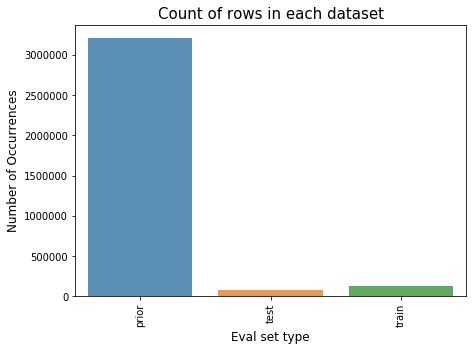

In [11]:
plt.figure(figsize=(7,5))
sns.barplot(a.index, a.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [12]:
print('priors {}: {}'.format(priors.shape, ', '.join(priors.columns)))
print('orders {}: {}'.format(orders.shape, ', '.join(orders.columns)))
print('train {}: {}'.format(train.shape, ', '.join(train.columns)))

priors (32434489, 4): order_id, product_id, add_to_cart_order, reordered
orders (3421083, 7): order_id, user_id, eval_set, order_number, order_dow, order_hour_of_day, days_since_prior_order
train (1384617, 4): order_id, product_id, add_to_cart_order, reordered


# project guideline

1. reshape data
2. find predictor features and feature engineering 
3. train and fit RF model, tune the parameters
4. use fine-tuned model for prediction

### Organizing data from multiple tables

#### We transform the data in order to facilitate their further analysis. First, we convert character variables into categories so we can use them in the creation of the model. In Python, a categorical variable is called category and has a fixed number of different values.

In [13]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')


In [14]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null category
dtypes: category(1), int64(1)
memory usage: 7.4 KB


## merge DataFrames orders and prior

In [15]:
op = orders.merge(priors, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


# 2. Create Predictor Variables
We are now ready to identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:

* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased.
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user.
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

For product predictors

1. Number of purchases for each product -- reorders
2. What is the probability for a product to be reordered  --reorder rate

In [16]:
print('computing product f')
prods = pd.DataFrame()
prods['orders'] = op.groupby(op.product_id).size()
#reorders
prods['reorders'] = op['reordered'].groupby(op.product_id).sum()
#reorder_rate
prods['reorder_rate'] = (prods.reorders / prods.orders)
prods=prods.reset_index()
prods.head()

computing product f


,product_id,orders,reorders,reorder_rate
0,1,1852,1136.0,0.613391
1,2,90,12.0,0.133333
2,3,277,203.0,0.732852
3,4,329,147.0,0.446809
4,5,15,9.0,0.600000


In [17]:
prods['reorder_rate'] = prods['reorder_rate'].fillna(value=0)
prods.head()

,product_id,orders,reorders,reorder_rate
0,1,1852,1136.0,0.613391
1,2,90,12.0,0.133333
2,3,277,203.0,0.732852
3,4,329,147.0,0.446809
4,5,15,9.0,0.600000


In [18]:
# print('add order info to priors')
# orders.set_index('order_id', inplace=True, drop=False)
# priors = priors.join(orders, on='order_id', rsuffix='_')
# priors.drop('order_id_', inplace=True, axis=1)

In [19]:
# priors.head(2)

### user features
1. average_days_between_orders 
2. Number of orders per customer
3. How frequent a customer has reordered products total times of order/total number of purchased products from all baskets

In [20]:
### analysis user features

print('computing user f')
usr = pd.DataFrame()
#group by user_id to find the time between orders
usr['average_days_between_orders'] = op.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
#user total orders
usr['nb_orders'] = op.groupby('user_id').size().astype(np.int16)
usr['user_reorder_rate']=op.groupby('user_id')['reordered'].mean()
usr=usr.reset_index()
usr['user_reorder_rate']=usr['user_reorder_rate'].fillna(value=0)
usr.head()

#user total items
#
#users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)#find the unique product_id
#users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

#users = users.join(usr)
#del usr
#average purchase number
#users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
#print('user f', users.shape)

computing user f


,user_id,average_days_between_orders,nb_orders,user_reorder_rate
0,1,20.259260,59,0.694915
1,2,15.967033,195,0.476923
2,3,11.487180,88,0.625000
3,4,15.357142,18,0.055556
4,5,14.500000,37,0.378378


In [21]:
# users.head(2)

In [22]:
# user_orders = users.sort_values(by='total_items', ascending=False)
# user_orders.reset_index().head(2)

### userXproduct features
1. How many times a user bought a product
2. How frequently a customer bought a product after its first purchase

In [23]:
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp=uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [24]:
#Times_Bought_N = Times a user bought a product
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']

#Order_Range_D = Total orders placed since the first user's order of a product
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
#In order to calculate the order number where the user bought a product for first time ('first_order_number'
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()

In [25]:
#merge 
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
#We divide the Times_Bought_N by the Order_Range_D for each user and product.
del [times, first_order_no, span]
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')
del uxp_ratio


In [26]:
uxp = uxp.fillna(0)
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


## merger all features

In [27]:
data=uxp.merge(usr,on='user_id',how = 'left')
data=data.merge(prods,on='product_id',how = 'left')

In [28]:
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,average_days_between_orders,nb_orders,user_reorder_rate,orders,reorders,reorder_rate
0,1,196,10,1.000000,20.25926,59,0.694915,35791,27791.0,0.776480
1,1,10258,9,1.000000,20.25926,59,0.694915,1946,1389.0,0.713772
2,1,10326,1,0.166667,20.25926,59,0.694915,5526,3603.0,0.652009
3,1,12427,10,1.000000,20.25926,59,0.694915,6476,4797.0,0.740735
4,1,13032,3,0.333333,20.25926,59,0.694915,3751,2465.0,0.657158


## feature selection

In [29]:
corr=data.corr()

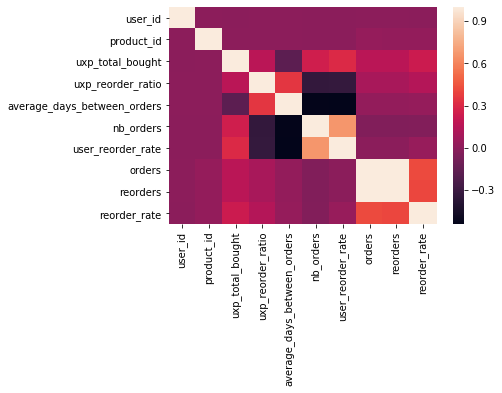

In [30]:
sns.heatmap(corr)

In [31]:
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797


In [32]:
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,average_days_between_orders,nb_orders,user_reorder_rate,orders,reorders,reorder_rate,eval_set,order_id
0,1,196,10,1.000000,20.25926,59,0.694915,35791,27791.0,0.776480,train,1187899
1,1,10258,9,1.000000,20.25926,59,0.694915,1946,1389.0,0.713772,train,1187899
2,1,10326,1,0.166667,20.25926,59,0.694915,5526,3603.0,0.652009,train,1187899
3,1,12427,10,1.000000,20.25926,59,0.694915,6476,4797.0,0.740735,train,1187899
4,1,13032,3,0.333333,20.25926,59,0.694915,3751,2465.0,0.657158,train,1187899
5,1,13176,2,0.222222,20.25926,59,0.694915,379450,315913.0,0.832555,train,1187899
6,1,14084,1,0.100000,20.25926,59,0.694915,15935,12923.0,0.810982,train,1187899
7,1,17122,1,0.166667,20.25926,59,0.694915,13880,9377.0,0.675576,train,1187899
8,1,25133,8,1.000000,20.25926,59,0.694915,6196,4586.0,0.740155,train,1187899
9,1,26088,2,0.200000,20.25926,59,0.694915,2523,1360.0,0.539041,train,1187899


# prepare train data

In [44]:
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,average_days_between_orders,nb_orders,user_reorder_rate,orders,reorders,reorder_rate,eval_set,order_id
0,1,196,10,1.000000,20.25926,59,0.694915,35791,27791.0,0.776480,train,1187899
1,1,10258,9,1.000000,20.25926,59,0.694915,1946,1389.0,0.713772,train,1187899
2,1,10326,1,0.166667,20.25926,59,0.694915,5526,3603.0,0.652009,train,1187899
3,1,12427,10,1.000000,20.25926,59,0.694915,6476,4797.0,0.740735,train,1187899
4,1,13032,3,0.333333,20.25926,59,0.694915,3751,2465.0,0.657158,train,1187899


In [45]:
data_train = data_train.merge(train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,average_days_between_orders,nb_orders,user_reorder_rate,orders,reorders,reorder_rate,eval_set,order_id,reordered
0,1,196,10,1.000000,20.25926,59,0.694915,35791,27791.0,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,20.25926,59,0.694915,1946,1389.0,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,20.25926,59,0.694915,5526,3603.0,0.652009,train,1187899,NaN
3,1,12427,10,1.000000,20.25926,59,0.694915,6476,4797.0,0.740735,train,1187899,NaN
4,1,13032,3,0.333333,20.25926,59,0.694915,3751,2465.0,0.657158,train,1187899,1.0


In [46]:
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,average_days_between_orders,nb_orders,user_reorder_rate,orders,reorders,reorder_rate,eval_set,order_id,reordered
0,1,196,10,1.000000,20.25926,59,0.694915,35791,27791.0,0.776480,train,1187899,1.0
1,1,10258,9,1.000000,20.25926,59,0.694915,1946,1389.0,0.713772,train,1187899,1.0
2,1,10326,1,0.166667,20.25926,59,0.694915,5526,3603.0,0.652009,train,1187899,0.0
3,1,12427,10,1.000000,20.25926,59,0.694915,6476,4797.0,0.740735,train,1187899,0.0
4,1,13032,3,0.333333,20.25926,59,0.694915,3751,2465.0,0.657158,train,1187899,1.0


In [48]:
data_train.corr()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,average_days_between_orders,nb_orders,user_reorder_rate,orders,reorders,reorder_rate,order_id,reordered
user_id,1.000000,-0.000438,-0.001855,0.002895,0.005782,-0.003345,-0.008463,-0.000670,-0.000563,-0.001399,-0.003826,-0.000429
product_id,-0.000438,1.000000,0.003016,0.001275,0.001707,-0.000785,-0.001820,0.035054,0.026405,0.025790,0.000312,0.002786
uxp_total_bought,-0.001855,0.003016,1.000000,0.167993,-0.170775,0.247747,0.306000,0.163652,0.164391,0.233215,0.000654,0.248376
uxp_reorder_ratio,0.002895,0.001275,0.167993,1.000000,0.354593,-0.335178,-0.325962,0.100254,0.101346,0.139354,0.002019,0.281601
average_days_between_orders,0.005782,0.001707,-0.170775,0.354593,1.000000,-0.534576,-0.540866,0.028006,0.027780,0.033879,0.002197,0.071201
nb_orders,-0.003345,-0.000785,0.247747,-0.335178,-0.534576,1.000000,0.667256,-0.038010,-0.038165,-0.032081,0.002354,-0.059297
user_reorder_rate,-0.008463,-0.001820,0.306000,-0.325962,-0.540866,0.667256,1.000000,-0.000648,-0.002182,0.038794,0.001326,0.007100
orders,-0.000670,0.035054,0.163652,0.100254,0.028006,-0.038010,-0.000648,1.000000,0.996233,0.419904,-0.000462,0.126969
reorders,-0.000563,0.026405,0.164391,0.101346,0.027780,-0.038165,-0.002182,0.996233,1.000000,0.407602,-0.000335,0.126898
reorder_rate,-0.001399,0.025790,0.233215,0.139354,0.033879,-0.032081,0.038794,0.419904,0.407602,1.000000,0.000602,0.167360


In [36]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head()

uxp_total_bought  uxp_reorder_ratio  \
user_id product_id                                        
1       196                       10           1.000000   
        10258                      9           1.000000   
        10326                      1           0.166667   
        12427                     10           1.000000   
        13032                      3           0.333333   

                    average_days_between_orders  nb_orders  user_reorder_rate  \
user_id product_id                                                              
1       196                            20.25926         59           0.694915   
        10258                          20.25926         59           0.694915   
        10326                          20.25926         59           0.694915   
        12427                          20.25926         59           0.694915   
        13032                          20.25926         59           0.694915   

                    orders  reorders  reorder_rate eval_set  order_id  \
user_id product_id                                                      
1       196          35791   27791.0      0.776480    train   1187899   
        10258         1946    1389.0      0.713772    train   1187899   
        10326         5526    3603.0      0.652009    train   1187899   
        12427         6476    4797.0      0.740735    train   1187899   
        13032         3751    2465.0      0.657158    train   1187899   

                    reordered  
user_id product_id             
1       196               1.0  
        10258             1.0  
        10326             0.0  
        12427             0.0  
        13032             1.0

In [37]:
#remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id','reorders'], axis=1)
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  \
user_id product_id                                        
1       196                       10           1.000000   
        10258                      9           1.000000   
        10326                      1           0.166667   
        12427                     10           1.000000   
        13032                      3           0.333333   
        13176                      2           0.222222   
        14084                      1           0.100000   
        17122                      1           0.166667   
        25133                      8           1.000000   
        26088                      2           0.200000   
        26405                      2           0.200000   
        30450                      1           0.125000   
        35951                      1           1.000000   
        38928                      1           1.000000   
        39657                      1           1.000000   

                    average_days_between_orders  nb_orders  user_reorder_rate  \
user_id product_id                                                              
1       196                            20.25926         59           0.694915   
        10258                          20.25926         59           0.694915   
        10326                          20.25926         59           0.694915   
        12427                          20.25926         59           0.694915   
        13032                          20.25926         59           0.694915   
        13176                          20.25926         59           0.694915   
        14084                          20.25926         59           0.694915   
        17122                          20.25926         59           0.694915   
        25133                          20.25926         59           0.694915   
        26088                          20.25926         59           0.694915   
        26405                          20.25926         59           0.694915   
        30450                          20.25926         59           0.694915   
        35951                          20.25926         59           0.694915   
        38928                          20.25926         59           0.694915   
        39657                          20.25926         59           0.694915   

                    orders  reorder_rate  reordered  
user_id product_id                                   
1       196          35791      0.776480        1.0  
        10258         1946      0.713772        1.0  
        10326         5526      0.652009        0.0  
        12427         6476      0.740735        0.0  
        13032         3751      0.657158        1.0  
        13176       379450      0.832555        0.0  
        14084        15935      0.810982        0.0  
        17122        13880      0.675576        0.0  
        25133         6196      0.740155        1.0  
        26088         2523      0.539041        1.0  
        26405         1214      0.441516        1.0  
        30450        21490      0.566682        0.0  
        35951        57895      0.757837        0.0  
        38928        13238      0.827769        1.0  
        39657         5019      0.766288        1.0

### same for the test data

In [38]:
data_test = data[data.eval_set=='test']
data_test = data_test.set_index(['user_id', 'product_id'])
data_test = data_test.drop(['eval_set','order_id','reorders'], axis=1)
data_test.head()

uxp_total_bought  uxp_reorder_ratio  \
user_id product_id                                        
3       248                        1           0.090909   
        1005                       1           0.333333   
        1819                       3           0.333333   
        7503                       1           0.100000   
        8021                       1           0.090909   

                    average_days_between_orders  nb_orders  user_reorder_rate  \
user_id product_id                                                              
3       248                            11.48718         88              0.625   
        1005                           11.48718         88              0.625   
        1819                           11.48718         88              0.625   
        7503                           11.48718         88              0.625   
        8021                           11.48718         88              0.625   

                    orders  reorder_rate  
user_id product_id                        
3       248           6371      0.400251  
        1005           463      0.440605  
        1819          2424      0.492162  
        7503         12474      0.553551  
        8021         27864      0.591157

Create predictive model
random forest

                             importance
average_days_between_orders    0.175669
user_reorder_rate              0.169913
reorder_rate                   0.155996
nb_orders                      0.152425
orders                         0.143934
uxp_reorder_ratio              0.134780
uxp_total_bought               0.067283


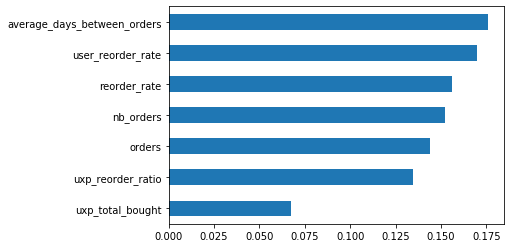

In [39]:
# TRAIN FULL 

from sklearn.ensemble import RandomForestClassifier

X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered

rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1 ,random_state=42)
model = rfc.fit(X_train, y_train)


feature_importances_df = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances_df)


feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
feat_importances.plot(kind='barh')

## Tune parameters

In [41]:
# Import GridSearchCV from scikit-learn
from sklearn.model_selection import GridSearchCV

# Create a range of values for different parameters
param_grid = {
    'max_depth': [4,5,6],
    'max_features': [3, 4, 5],
    'n_estimators': [10, 16, 20]
}

# Select a fitting model without any parameter
rfc = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rfc, n_jobs=None,  param_grid = param_grid, 
                          cv = 3, )

# FIT our model with the combinations of different parameters - here is where GridSearch will be exeucuted
grid_search.fit(X_train, y_train)

# Print the best parameters
print("The best parameters are: /n",  grid_search.best_params_)

# Store the model for prediction (chapter 5)
model = grid_search.best_estimator_

# Delete X_train , y_train
#del [X_train, y_train, rfc]

The best parameters are: /n {'max_depth': 6, 'max_features': 4, 'n_estimators': 20}


In [ ]:
model.get_params()

## Apply predictive model (predict)

In [50]:
# Predict values for test data with our model from chapter 5 - the results are saved as a Python array
test_pred = model.predict(data_test).astype(int)

## OR Set custom threshold 
test_pred = (model.predict_proba(data_test)[:,1] >= 0.15).astype(int)

test_pred[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [51]:
data_test['prediction'] = test_pred
data_test.head(10)

uxp_total_bought  uxp_reorder_ratio  \
user_id product_id                                        
3       248                        1           0.090909   
        1005                       1           0.333333   
        1819                       3           0.333333   
        7503                       1           0.100000   
        8021                       1           0.090909   
        9387                       5           0.416667   
        12845                      1           0.111111   
        14992                      2           0.285714   
        15143                      1           0.083333   
        16797                      3           0.250000   

                    average_days_between_orders  nb_orders  user_reorder_rate  \
user_id product_id                                                              
3       248                            11.48718         88              0.625   
        1005                           11.48718         88              0.625   
        1819                           11.48718         88              0.625   
        7503                           11.48718         88              0.625   
        8021                           11.48718         88              0.625   
        9387                           11.48718         88              0.625   
        12845                          11.48718         88              0.625   
        14992                          11.48718         88              0.625   
        15143                          11.48718         88              0.625   
        16797                          11.48718         88              0.625   

                    orders  reorder_rate  prediction  
user_id product_id                                    
3       248           6371      0.400251           0  
        1005           463      0.440605           0  
        1819          2424      0.492162           0  
        7503         12474      0.553551           0  
        8021         27864      0.591157           0  
        9387         36187      0.650427           1  
        12845        10027      0.362920           0  
        14992        29069      0.582820           0  
        15143         3447      0.492022           0  
        16797       142951      0.698155           0

In [57]:
#Reset the index
final = data_test.reset_index()
#Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]

final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [58]:
orders_test = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [59]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [60]:
final = final.drop('user_id', axis=1)

In [61]:
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

In [62]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'

In [63]:
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,9387 17668 18599 21903 22035 39190 43961 47766
1,329954,21573
2,1528013,8424 21903 38293
3,1376945,4799 8309 8670 13176 14947 17706 17794 20383 2...
4,1356845,5746 7076 7120 8239 10863 11520 13176 14992 16...


In [19]:
# ### userXproduct features
# priors['user_product'] = priors.product_id + priors.user_id * 100000

In [20]:
# d = dict()

# for row in priors.itertuples():
#     z = row.user_product
#     if z not in d:
#         d[z] = (1,
#                 (row.order_number, row.order_id),
#                 row.add_to_cart_order)
#     else:
#         d[z] = (d[z][0] + 1,
#                 max(d[z][1], (row.order_number, row.order_id)),
#                 d[z][2] + row.add_to_cart_order)

# print('to dataframe (less memory)')
# userXproduct = pd.DataFrame.from_dict(d, orient='index')
# del d
# userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
# userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
# userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
# userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
# print('user X product f', len(userXproduct))

# del priors

to dataframe (less memory)
user X product f 13293564


In [21]:
userXproduct.head(2)

,nb_orders,last_order_id,sum_pos_in_cart
-1246903360,5,104690,10
-1246907495,5,132412,16


In [22]:
### train / test orders ###
print('split orders : train, test')
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

split orders : train, test


In [47]:
### build list of candidate products to reorder, with features ###

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
#     enumerate()
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    print('user related features')
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    print('order related features')
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    print('product related features')
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    print('user_X_product related features')
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    #df['UP_same_dow_as_last_order'] = df.UP_last_order_id.map(orders.order_dow) == \
    #                                              df.order_id.map(orders.order_dow)

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)


In [49]:
df_train.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,4,13880,9377.0,0.675576,1,0.090909,6.0,0.090909,6,7
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,7,35791,27791.0,0.776480,10,0.909091,1.4,0.909091,1,0
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,...,17,1214,536.0,0.441516,2,0.181818,5.0,0.181818,7,1
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,...,7,8558,6953.0,0.812456,3,0.272727,3.0,0.272727,1,0
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,...,16,15935,12923.0,0.810982,1,0.090909,2.0,0.090909,10,0


In [24]:
df_train, labels = features(train_orders, labels_given=True)

build candidate list
order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
user related features
order related features
product related features
user_X_product related features
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                      int8
days_since_prior_order              float32
days_since_ratio                    float32
aisle_id                              uint8
department_id                         uint8
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_or

In [25]:
df_train.head(2)

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,...,4,13880,9377.0,0.675576,1,0.090909,6.0,0.090909,6,7
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,...,7,35791,27791.0,0.776480,10,0.909091,1.4,0.909091,1,0


In [26]:
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] # 'dow', 'UP_same_dow_as_last_order'

In [27]:
rf = RandomForestClassifier()
rf = rf.fit(df_train[f_to_use], labels)


df_test, _ = features(test_orders)
preds = rf.predict(df_test[f_to_use])

df_test['pred'] = preds

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)




C:\Users\Roy\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').